Using device: cuda


100%|██████████| 792M/792M [00:44<00:00, 17.7MB/s]
100%|██████████| 19.2M/19.2M [00:02<00:00, 8.51MB/s]



Starting Training for 10 Epochs...
--- Epoch [1/10] Finished --- Avg Loss: 0.4419 --- LR: 0.001 ---
--- Epoch [2/10] Finished --- Avg Loss: 0.3492 --- LR: 0.001 ---
--- Epoch [3/10] Finished --- Avg Loss: 0.3007 --- LR: 0.001 ---
--- Epoch [4/10] Finished --- Avg Loss: 0.2664 --- LR: 0.001 ---
--- Epoch [5/10] Finished --- Avg Loss: 0.2307 --- LR: 0.0001 ---


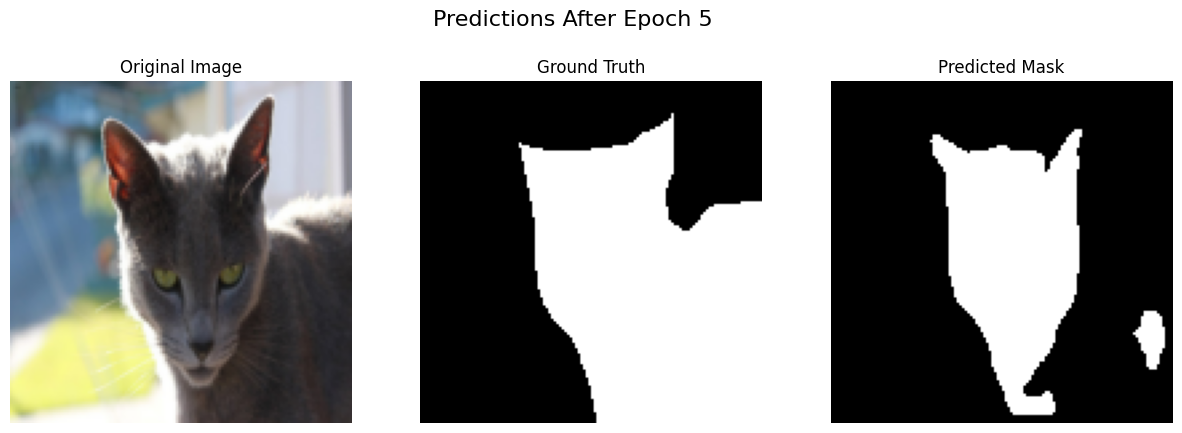

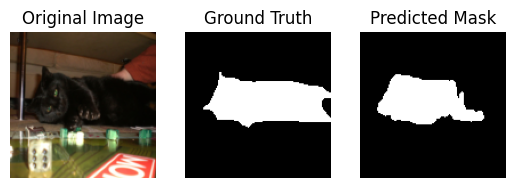

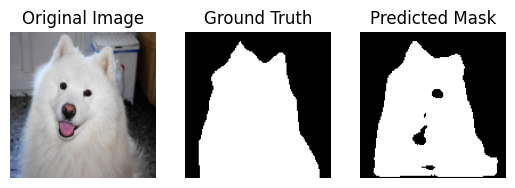

--- Epoch [6/10] Finished --- Avg Loss: 0.2207 --- LR: 0.0001 ---
--- Epoch [7/10] Finished --- Avg Loss: 0.2139 --- LR: 0.0001 ---
--- Epoch [8/10] Finished --- Avg Loss: 0.2084 --- LR: 0.0001 ---
--- Epoch [9/10] Finished --- Avg Loss: 0.2019 --- LR: 1e-05 ---
--- Epoch [10/10] Finished --- Avg Loss: 0.1993 --- LR: 1e-05 ---


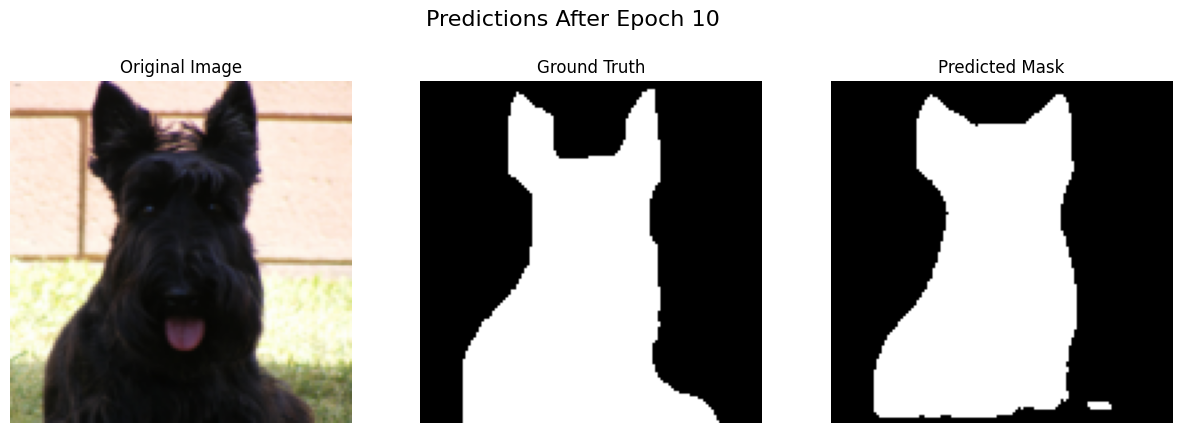

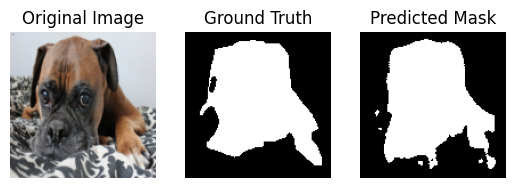

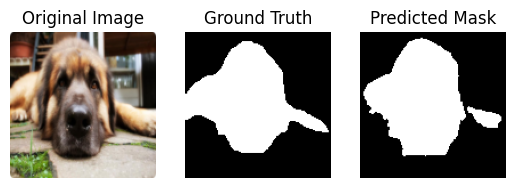

Training finished.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import v2 as T
import matplotlib.pyplot as plt

# --- 1. Define the U-Net Model Architecture ---
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )
        # Encoder Path
        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Bottleneck
        self.bottleneck = conv_block(256, 512)
        # Decoder Path
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)
        # Output Layer
        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x); p1 = self.pool1(e1)
        e2 = self.encoder2(p1); p2 = self.pool2(e2)
        e3 = self.encoder3(p2); p3 = self.pool3(e3)
        b = self.bottleneck(p3)
        d3 = self.decoder3(torch.cat((e3, self.upconv3(b)), dim=1))
        d2 = self.decoder2(torch.cat((e2, self.upconv2(d3)), dim=1))
        d1 = self.decoder1(torch.cat((e1, self.upconv1(d2)), dim=1))
        return self.output_layer(d1)

# --- 2. Create the Custom Dataset ---
class PetDataset(OxfordIIITPet):
    def __init__(self, root, split, common_transforms=None):
        super().__init__(root=root, split=split, download=True, target_types="segmentation")
        self.common_transforms = common_transforms
        self.normalize_image = T.Compose([
            T.ToDtype(torch.float32, scale=True),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __getitem__(self, idx):
        image, mask = super().__getitem__(idx)
        if self.common_transforms:
            image, mask = self.common_transforms(image, mask)
        mask = (mask == 1).to(torch.float32)
        image = self.normalize_image(image)
        return image, mask

# --- 3. Define a Helper Function for Visualization ---
def show_predictions(model, loader, device, epoch):
    model.eval()
    images, masks = next(iter(loader))
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5

    inv_normalize = T.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    plt.figure(figsize=(15, 5))
    plt.suptitle(f'Predictions After Epoch {epoch+1}', fontsize=16)

    for i in range(min(3, len(images))):
        img_display = inv_normalize(images[i]).cpu().permute(1, 2, 0).clamp(0, 1)
        plt.subplot(1, 3, 1)
        plt.imshow(img_display); plt.title('Original Image'); plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].cpu().squeeze(), cmap='gray'); plt.title('Ground Truth'); plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(preds[i].cpu().squeeze(), cmap='gray'); plt.title('Predicted Mask'); plt.axis('off')
        plt.show()

# --- 4. Main Training Script ---
if __name__ == '__main__':
    # Configuration
    IMG_SIZE = 128
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 10  # Training for 10 epochs
    DATA_DIR = "./data"

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Data Loading and Preprocessing
    common_transforms = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.ToImage(),
    ])

    train_dataset = PetDataset(root=DATA_DIR, split="trainval", common_transforms=common_transforms)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    val_dataset = PetDataset(root=DATA_DIR, split="test", common_transforms=common_transforms)
    val_loader = DataLoader(val_dataset, batch_size=3, shuffle=True)

    # Model, Loss, and Optimizer
    model = UNet(in_channels=3, out_channels=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

    # Training Loop
    print("\nStarting Training for 10 Epochs...")
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"--- Epoch [{epoch+1}/{NUM_EPOCHS}] Finished --- Avg Loss: {epoch_loss:.4f} --- LR: {current_lr} ---")

        scheduler.step()

        # Show predicted mask every 5 epochs
        if (epoch + 1) % 5 == 0:
            show_predictions(model, val_loader, device, epoch)

    print("Training finished.")

Using device: cuda

--- Displaying 5 Validation Images and Scores ---


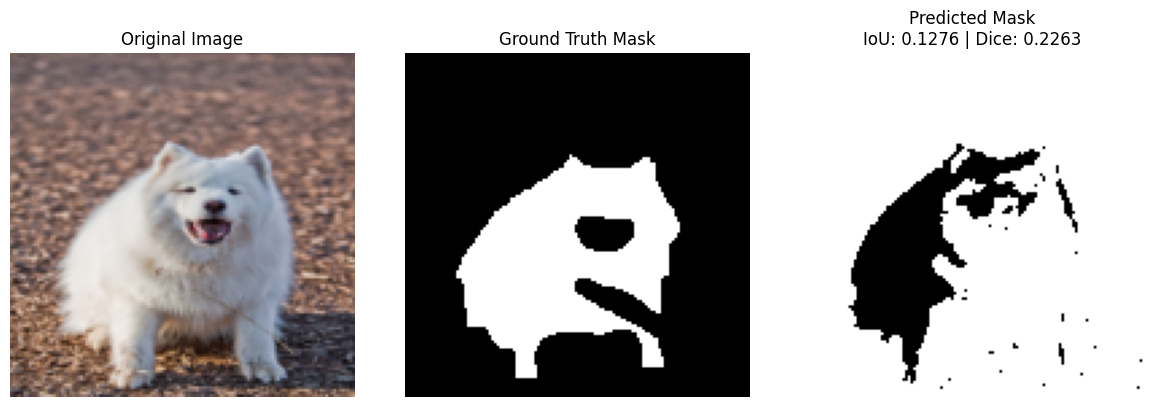

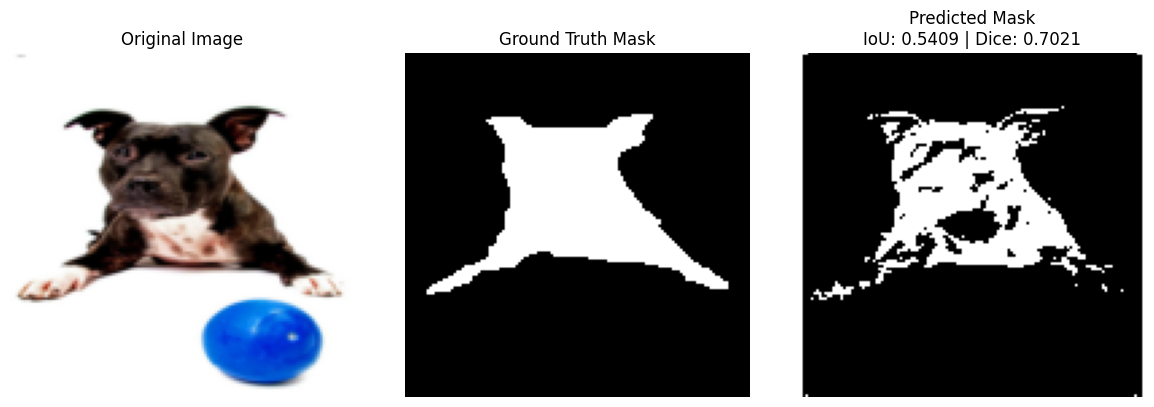

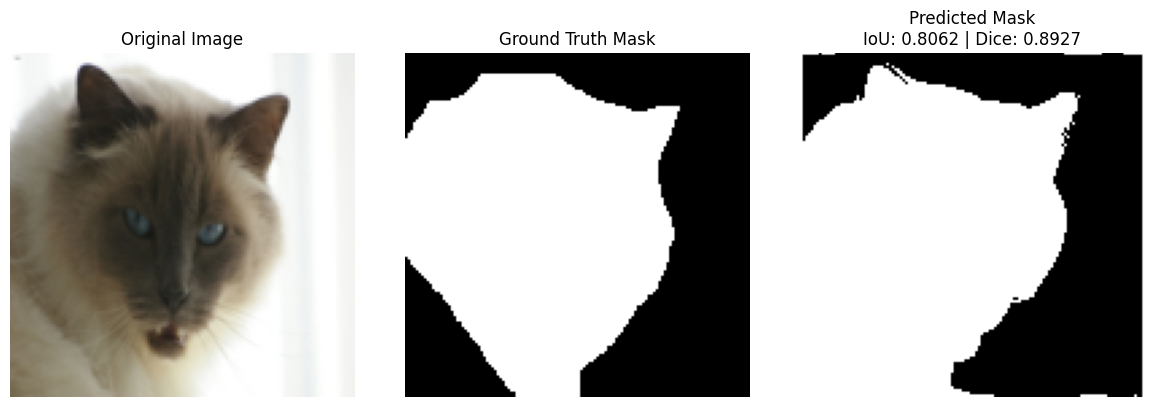

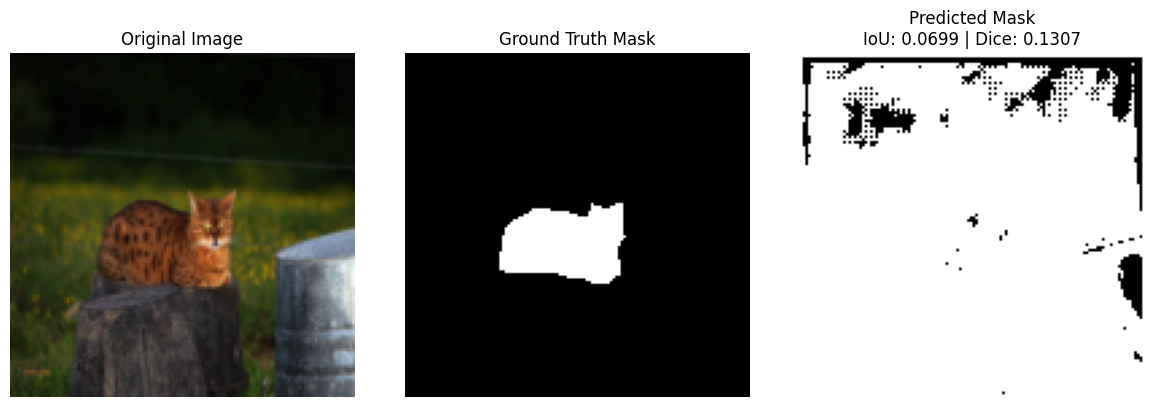

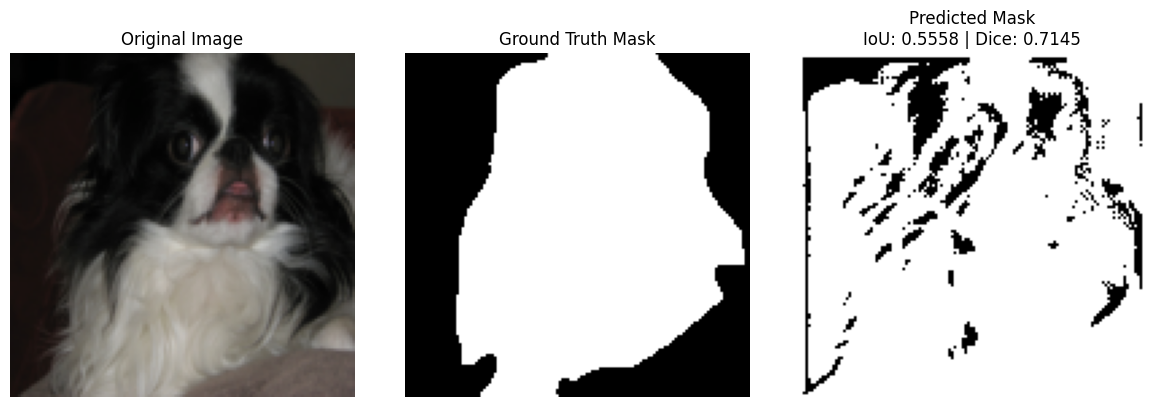

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import v2 as T
import matplotlib.pyplot as plt

# --- 1. Define the U-Net Model Architecture ---
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )
        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = conv_block(256, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)
        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x); p1 = self.pool1(e1)
        e2 = self.encoder2(p1); p2 = self.pool2(e2)
        e3 = self.encoder3(p2); p3 = self.pool3(e3)
        b = self.bottleneck(p3)
        d3 = self.decoder3(torch.cat((e3, self.upconv3(b)), dim=1))
        d2 = self.decoder2(torch.cat((e2, self.upconv2(d3)), dim=1))
        d1 = self.decoder1(torch.cat((e1, self.upconv1(d2)), dim=1))
        return self.output_layer(d1)

# --- 2. Create the Custom Dataset ---
class PetDataset(OxfordIIITPet):
    def __init__(self, root, split, common_transforms=None):
        super().__init__(root=root, split=split, download=True, target_types="segmentation")
        self.common_transforms = common_transforms
        self.normalize_image = T.Compose([
            T.ToDtype(torch.float32, scale=True),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __getitem__(self, idx):
        image, mask = super().__getitem__(idx)
        if self.common_transforms:
            image, mask = self.common_transforms(image, mask)
        mask = (mask == 1).to(torch.float32)
        image = self.normalize_image(image)
        return image, mask

# --- 3. Define Metric and Visualization Functions ---
def compute_iou(pred, true, threshold=0.5):
    pred_bin = (pred > threshold).float()
    true_bin = (true > 0.5).float()
    inter = (pred_bin * true_bin).sum()
    union = pred_bin.sum() + true_bin.sum() - inter + 1e-7
    return (inter / union).item()

def compute_dice(pred, true, threshold=0.5):
    pred_bin = (pred > threshold).float()
    true_bin = (true > 0.5).float()
    inter = (pred_bin * true_bin).sum()
    return (2 * inter / (pred_bin.sum() + true_bin.sum() + 1e-7)).item()

def evaluate_and_display(model, loader, device):
    print("\n--- Displaying 5 Validation Images and Scores ---")
    model.eval()
    images, masks = next(iter(loader))
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds_probs = torch.sigmoid(outputs)
        preds_binary = preds_probs > 0.5

    inv_normalize = T.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    for i in range(len(images)):
        img_display = inv_normalize(images[i]).cpu().permute(1, 2, 0).clamp(0, 1)
        true_mask_display = masks[i].cpu().squeeze()
        pred_mask_display = preds_binary[i].cpu().squeeze()

        iou_score = compute_iou(preds_probs[i], masks[i])
        dice_score = compute_dice(preds_probs[i], masks[i])

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img_display); plt.title('Original Image'); plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask_display, cmap='gray'); plt.title('Ground Truth Mask'); plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask_display, cmap='gray')
        plt.title(f'Predicted Mask\nIoU: {iou_score:.4f} | Dice: {dice_score:.4f}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# --- 4. Main Script ---
if __name__ == '__main__':
    IMG_SIZE = 128
    DATA_DIR = "./data"

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    common_transforms = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.ToImage(),
    ])

    val_dataset = PetDataset(root=DATA_DIR, split="test", common_transforms=common_transforms)
    val_loader = DataLoader(val_dataset, batch_size=5, shuffle=True)

    # Initialize the model with random, untrained weights
    model = UNet(in_channels=3, out_channels=1).to(device)

    # Run the evaluation and display the results
    evaluate_and_display(model, val_loader, device)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import v2 as T
import matplotlib.pyplot as plt

# --- U-Net Model Architecture ---
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
            )
        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.bottleneck = conv_block(256, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)
        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x); p1 = self.pool1(e1)
        e2 = self.encoder2(p1); p2 = self.pool2(e2)
        e3 = self.encoder3(p2); p3 = self.pool3(e3)
        b = self.bottleneck(p3)
        d3 = self.decoder3(torch.cat((e3, self.upconv3(b)), dim=1))
        d2 = self.decoder2(torch.cat((e2, self.upconv2(d3)), dim=1))
        d1 = self.decoder1(torch.cat((e1, self.upconv1(d2)), dim=1))
        return self.output_layer(d1)

# --- Custom Dataset ---
class PetDataset(OxfordIIITPet):
    def __init__(self, root, split, common_transforms=None):
        super().__init__(root=root, split=split, download=False, target_types="segmentation")
        self.common_transforms = common_transforms
        self.normalize_image = T.Compose([
            T.ToDtype(torch.float32, scale=True),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __getitem__(self, idx):
        image, mask = super().__getitem__(idx)
        if self.common_transforms:
            image, mask = self.common_transforms(image, mask)
        mask = (mask == 1).to(torch.float32)
        image = self.normalize_image(image)
        return image, mask

# --- Main Training Script ---
if __name__ == '__main__':
    IMG_SIZE = 128
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 10
    DATA_DIR = "./data"
    MODEL_SAVE_PATH = 'unet_pet_model.pth'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    common_transforms = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToImage()])
    train_dataset = PetDataset(root=DATA_DIR, split="trainval", common_transforms=common_transforms)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    model = UNet(in_channels=3, out_channels=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

    print(f"\nStarting Training for {NUM_EPOCHS} Epochs...")
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        print(f"--- Epoch [{epoch+1}/{NUM_EPOCHS}] Finished --- Avg Loss: {epoch_loss:.4f} ---")
        scheduler.step()

    print("Training finished.")
    # Save the trained model's weights
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Model saved to {MODEL_SAVE_PATH}")

Using device: cuda


RuntimeError: Dataset not found. You can use download=True to download it

Model loaded from unet_pet_model.pth
Loading image from: /content/my_cat.jpg


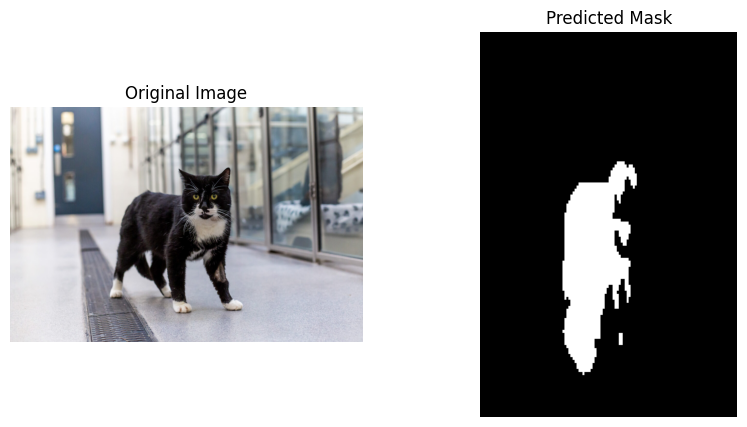

In [ ]:
import torch
import torch.nn as nn
from torchvision.transforms import v2 as T
from PIL import Image
import matplotlib.pyplot as plt
import os


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
            )
        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.bottleneck = conv_block(256, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)
        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x); p1 = self.pool1(e1)
        e2 = self.encoder2(p1); p2 = self.pool2(e2)
        e3 = self.encoder3(p2); p3 = self.pool3(e3)
        b = self.bottleneck(p3)
        d3 = self.decoder3(torch.cat((e3, self.upconv3(b)), dim=1))
        d2 = self.decoder2(torch.cat((e2, self.upconv2(d3)), dim=1))
        d1 = self.decoder1(torch.cat((e1, self.upconv1(d2)), dim=1))
        return self.output_layer(d1)


def predict_mask(model, image_path):
    IMG_SIZE = 128
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Preprocess the image
    image = Image.open(image_path).convert("RGB")
    original_size = image.size

    preprocess = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(image).unsqueeze(0).to(device)


    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.sigmoid(output) > 0.5


    pred_mask_resized = T.Resize(original_size, interpolation=T.InterpolationMode.NEAREST)(pred_mask)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask_resized.cpu().squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()


if __name__ == '__main__':

    MODEL_SAVE_PATH = 'unet_pet_model.pth'


    IMAGE_PATH = r"/content/my_cat.jpg"


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    try:
        inference_model = UNet(in_channels=3, out_channels=1).to(device)
        inference_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
        print(f"Model loaded from {MODEL_SAVE_PATH}")
    except FileNotFoundError:
        print(f"Error: Model file not found at '{MODEL_SAVE_PATH}'.")
        print("Please make sure you have run the training script first to create the model file.")
        exit()


    try:
        print(f"Loading image from: {IMAGE_PATH}")
        predict_mask(inference_model, IMAGE_PATH)
    except FileNotFoundError:
        print(f"Error: Image file not found at '{IMAGE_PATH}'.")
        print("Please make sure your image is in the same directory and the filename is correct.")

Model loaded from unet_pet_model.pth
Attempting to load image from: /content/my_cat.jpg


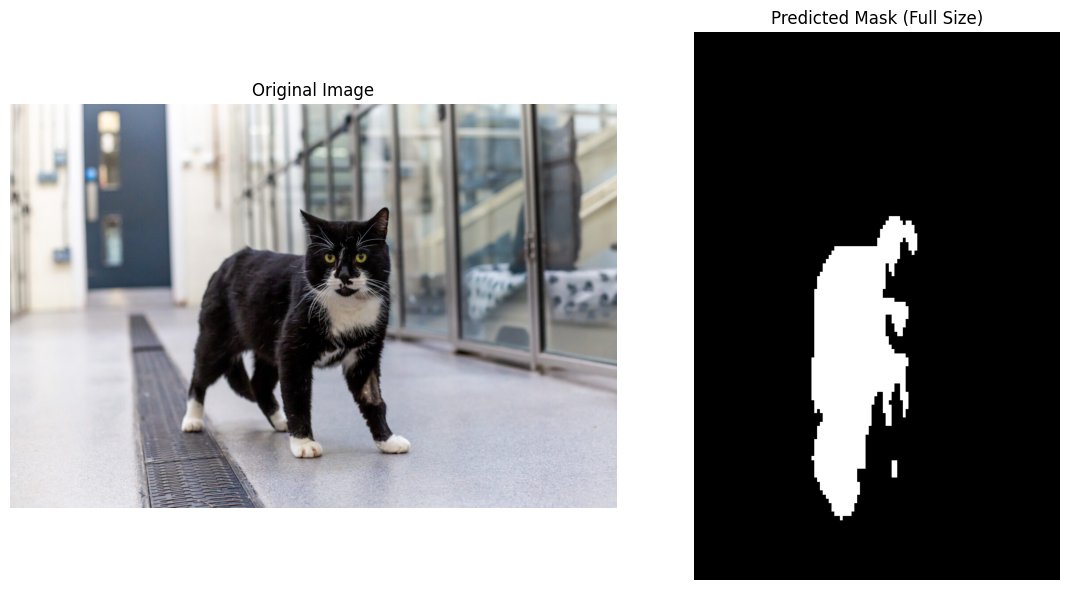

In [ ]:
import torch
import torch.nn as nn
from torchvision.transforms import v2 as T
from PIL import Image
import matplotlib.pyplot as plt
import os

# --- 1. Define the U-Net Model Architecture ---
# This must be the same architecture as the one you trained and saved.
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
            )
        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.bottleneck = conv_block(256, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)
        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x); p1 = self.pool1(e1)
        e2 = self.encoder2(p1); p2 = self.pool2(e2)
        e3 = self.encoder3(p2); p3 = self.pool3(e3)
        b = self.bottleneck(p3)
        d3 = self.decoder3(torch.cat((e3, self.upconv3(b)), dim=1))
        d2 = self.decoder2(torch.cat((e2, self.upconv2(d3)), dim=1))
        d1 = self.decoder1(torch.cat((e1, self.upconv1(d2)), dim=1))
        return self.output_layer(d1)

# --- 2. Define the Inference and Display Function ---
def predict_mask(model, image_path):
    IMG_SIZE = 128
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    image = Image.open(image_path).convert("RGB")
    original_size = image.size

    preprocess = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.sigmoid(output) > 0.5

    pred_mask_resized = T.Resize(original_size, interpolation=T.InterpolationMode.NEAREST)(pred_mask)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    # MODIFIED: Added aspect='equal' to maintain the original shape
    plt.imshow(image, aspect='equal')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    # MODIFIED: Added aspect='equal' here as well
    plt.imshow(pred_mask_resized.cpu().squeeze(), cmap='gray', aspect='equal')
    plt.title("Predicted Mask (Full Size)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- 3. Main Inference Pipeline ---
if __name__ == '__main__':
    MODEL_SAVE_PATH = 'unet_pet_model.pth'

    # --- Step 1: CHANGE THIS to the name of your image file ---
    IMAGE_PATH = "/content/my_cat.jpg"

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    try:
        inference_model = UNet(in_channels=3, out_channels=1).to(device)
        inference_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
        print(f"Model loaded from {MODEL_SAVE_PATH}")
    except FileNotFoundError:
        print(f"Error: Model file not found at '{MODEL_SAVE_PATH}'.")
        print("Please run the training script first to create the model file.")
        exit()

    try:
        print(f"Attempting to load image from: {IMAGE_PATH}")
        predict_mask(inference_model, IMAGE_PATH)
    except FileNotFoundError:
        print(f"Error: Image file not found at '{IMAGE_PATH}'.")
        print("Please make sure your image is in the same directory and the filename is correct.")

Error: Model file not found at 'unet_pet_model.pth'.
Loading image from: /my_cat.jpg


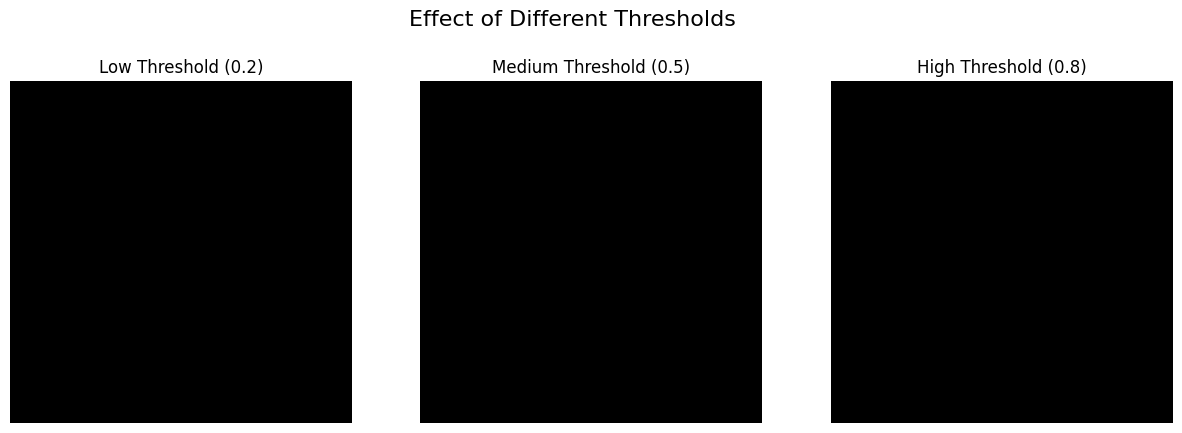


--- Metrics ---


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
import torch
import torch.nn as nn
from torchvision.transforms import v2 as T
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from skimage import measure, morphology

# --- 1. Define the U-Net Model Architecture ---
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
            )
        self.encoder1 = conv_block(in_channels, 64); self.pool1 = nn.MaxPool2d(2, 2)
        self.encoder2 = conv_block(64, 128); self.pool2 = nn.MaxPool2d(2, 2)
        self.encoder3 = conv_block(128, 256); self.pool3 = nn.MaxPool2d(2, 2)
        self.bottleneck = conv_block(256, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)
        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x); p1 = self.pool1(e1)
        e2 = self.encoder2(p1); p2 = self.pool2(e2)
        e3 = self.encoder3(p2); p3 = self.pool3(e3)
        b = self.bottleneck(p3)
        d3 = self.decoder3(torch.cat((e3, self.upconv3(b)), dim=1))
        d2 = self.decoder2(torch.cat((e2, self.upconv2(d3)), dim=1))
        d1 = self.decoder1(torch.cat((e1, self.upconv1(d2)), dim=1))
        return self.output_layer(d1)

# --- 2. Define Post-Processing and Metric Functions ---
def post_process_mask(mask_tensor):
    """Applies morphological opening and keeps the largest connected component."""
    mask_np = mask_tensor.cpu().squeeze().numpy().astype(np.uint8)
    kernel = morphology.disk(2)
    opened = morphology.opening(mask_np, kernel)
    labels = measure.label(opened)
    if labels.max() == 0:
        return torch.from_numpy(opened).unsqueeze(0).to(mask_tensor.device)
    largest_component_label = np.argmax(np.bincount(labels.flat)[1:]) + 1
    final_mask = (labels == largest_component_label).astype(np.uint8)
    return torch.from_numpy(final_mask).unsqueeze(0).to(mask_tensor.device)

def iou(pred,true,threshold=0.5):
    pred_bin = (pred>threshold).float(); true_bin = (true>0.5).float()
    inter = (pred_bin*true_bin).sum()
    union = pred_bin.sum()+true_bin.sum()-inter + 1e-7
    return (inter/union).item()

def dice(pred,true,threshold=0.5):
    pred_bin = (pred>threshold).float(); true_bin = (true>0.5).float()
    inter = (pred_bin*true_bin).sum()
    return (2*inter/(pred_bin.sum()+true_bin.sum()+1e-7)).item()

# --- 3. Main Analysis Function ---
def run_full_analysis(model, image_path, true_mask_for_metrics=None):
    IMG_SIZE = 128
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image = Image.open(image_path).convert("RGB")
    original_size = image.size
    preprocess = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)), T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        preds_probs = torch.sigmoid(outputs)

    # --- Thresholding Demonstration ---
    mask_low = preds_probs > 0.2
    mask_mid = preds_probs > 0.5
    mask_high = preds_probs > 0.8
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("Effect of Different Thresholds", fontsize=16)
    axes[0].imshow(mask_low.cpu().squeeze(), cmap='gray'); axes[0].set_title("Low Threshold (0.2)"); axes[0].axis('off')
    axes[1].imshow(mask_mid.cpu().squeeze(), cmap='gray'); axes[1].set_title("Medium Threshold (0.5)"); axes[1].axis('off')
    axes[2].imshow(mask_high.cpu().squeeze(), cmap='gray'); axes[2].set_title("High Threshold (0.8)"); axes[2].axis('off')
    plt.show()

    # --- Post-Processing and Metrics Comparison ---
    before_mask = preds_probs > 0.5
    after_mask = post_process_mask(before_mask)
    before_mask_resized = T.Resize(original_size, interpolation=T.InterpolationMode.NEAREST)(before_mask)
    after_mask_resized = T.Resize(original_size, interpolation=T.InterpolationMode.NEAREST)(after_mask)

    print("\n--- Metrics ---")
    if true_mask_for_metrics is not None:
        iou_before = iou(preds_probs, true_mask_for_metrics)
        dice_before = dice(preds_probs, true_mask_for_metrics)
        iou_after = iou(after_mask.float(), true_mask_for_metrics, threshold=0.5)
        dice_after = dice(after_mask.float(), true_mask_for_metrics, threshold=0.5)
        print(f"Before Post-Processing: IoU = {iou_before:.4f}, Dice = {dice_before:.4f}")
        print(f"After Post-Processing:  IoU = {iou_after:.4f}, Dice = {dice_after:.4f}")

    # Final Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle("Before vs. After Post-Processing", fontsize=16)
    axes[0].imshow(image); axes[0].set_title("Original Image"); axes[0].axis('off')
    axes[1].imshow(before_mask_resized.cpu().squeeze(), cmap='gray'); axes[1].set_title("Before Post-Processing"); axes[1].axis('off')
    axes[2].imshow(after_mask_resized.cpu().squeeze(), cmap='gray'); axes[2].set_title("After Post-Processing"); axes[2].axis('off')
    plt.show()

# --- 4. Main Execution Block ---
if __name__ == '__main__':
    MODEL_SAVE_PATH = 'unet_pet_model.pth'

    # --- Step 1: CHANGE THIS to the name of your image file ---
    IMAGE_PATH = "/my_cat.jpg"

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    try:
        inference_model = UNet(in_channels=3, out_channels=1).to(device)
        inference_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
        print(f"Model loaded from {MODEL_SAVE_PATH}")
    except FileNotFoundError:
        print(f"Error: Model file not found at '{MODEL_SAVE_PATH}'.")
        exit()

    if os.path.exists(IMAGE_PATH):
        print(f"Loading image from: {IMAGE_PATH}")
        # For a true evaluation, you would load the actual ground truth mask for your image.
        # Since we don't have it, we create a dummy mask to allow the metric functions to run.
        dummy_mask = torch.zeros(1, 1, 128, 128)
        run_full_analysis(inference_model, IMAGE_PATH, true_mask_for_metrics=dummy_mask)
    else:
        print(f"Error: Image file not found at '{IMAGE_PATH}'.")
        print("Please make sure your image is in the same directory and the filename is correct.")